# Ficha nr1 - Fashion mnist MLP


**Ruben Silva** - pg57900


### Imports

In [33]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import (
    Linear, ReLU, Softmax, CrossEntropyLoss,
)
from torch.nn.init import xavier_uniform_, kaiming_normal_
from torchinfo import summary

# Torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Live loss plot
from livelossplot import PlotLosses

# Sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Outros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


### Paths

In [34]:
PATH_TRAIN = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC1 CNN fashion mnist\\dataset\\fashion-mnist_train.csv'
PATH_TEST = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC1 CNN fashion mnist\\dataset\\fashion-mnist_test.csv'

## Tarefa 4 - MLP

**Setup**

In [35]:
device = torch.device("cpu")
BATCH_SIZE = 32


**Prepare Data**

In [36]:
class CSVDataset(Dataset):
    def __init__(self, path_train, path_test):
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        self.x_train = df_train.values[:, 1:]
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.y_test = df_test.values[:, 0]
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')

    def __len_train__(self):
        return len(self.x_train)
    
    def __len_test__(self):
        return len(self.x_test)
    
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
    
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    def get_splits_flat(self):
        x_train = torch.from_numpy(np.array(self.x_train))
        y_train = torch.from_numpy(np.array(self.y_train)).long()  # Explicitly cast to long
        x_test = torch.from_numpy(np.array(self.x_test))
        y_test = torch.from_numpy(np.array(self.y_test)).long()    # Explicitly cast to long
        train = torch.utils.data.TensorDataset(x_train, y_train)
        test = torch.utils.data.TensorDataset(x_test, y_test)
        return train, test


In [37]:
def prepare_data_flat(path_train, path_test):
    dataset = CSVDataset(path_train, path_test)
    train, test = dataset.get_splits_flat()
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)


**Visualize Data**

In [38]:
def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)
def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

    
visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:60000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([32, 784]), output: torch.Size([32])
Shape tensor batch casos test, input: torch.Size([32, 784]), output: torch.Size([32])
tensor([4, 6, 1, 7, 2, 5, 9, 5, 1, 3, 3, 7, 3, 6, 8, 5, 9, 2, 1, 6, 4, 0, 7, 8,
        2, 4, 4, 1, 3, 7, 7, 6])


torch.Size([32, 784])
torch.Size([32, 1, 28, 28])


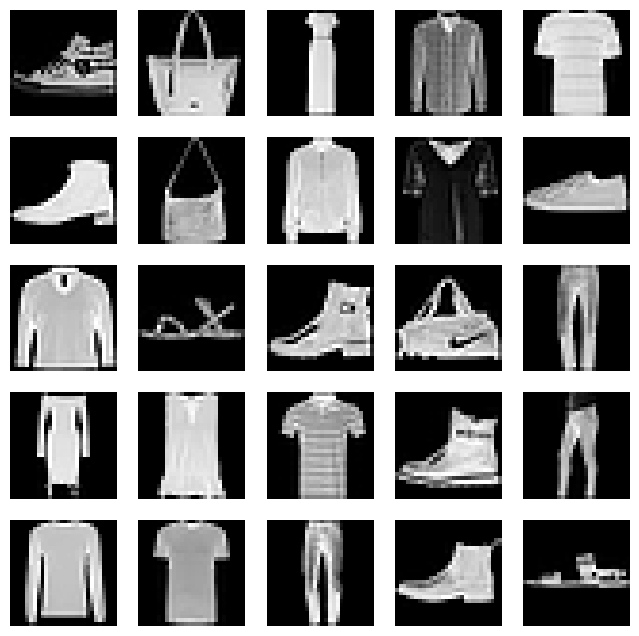

In [39]:
def visualize_mnist_images_flat(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(False)  #b=None
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images_flat(train_dl)


-----Train------
casos: 60000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
60000


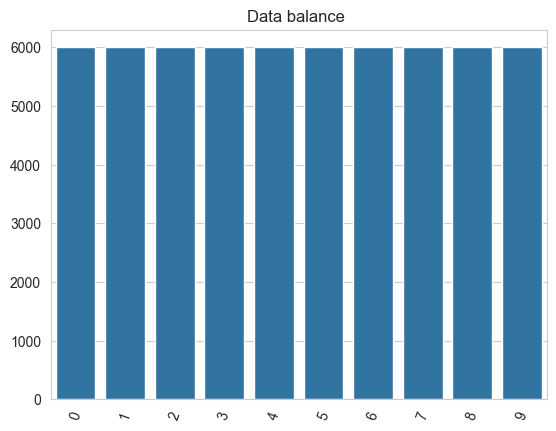

-----Test------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


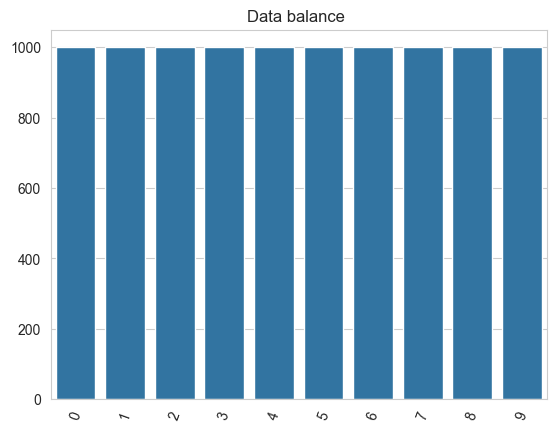

In [40]:
def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico = sns.barplot(x=x, y=y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.show()
     
print("-----Train------")   
visualize_holdout_balance(train_dl_all)
print("-----Test------") 
visualize_holdout_balance(test_dl_all)


**Model**

In [41]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size=784, output_size=10, hidden_sizes=[512, 256, 128], 
                 dropout_rates=[0.2, 0.3, 0.3], use_leaky=True, alpha=0.1):
        super(ImprovedMLP, self).__init__()
        
        # Allow configuration of hidden layers
        self.layers = nn.ModuleList()
        layer_sizes = [input_size] + hidden_sizes
        
        # Build the network dynamically based on parameters
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if use_leaky:
                self.layers.append(nn.LeakyReLU(alpha))
            else:
                self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
            self.layers.append(nn.Dropout(dropout_rates[i]))
        
        # Output layer
        self.output = nn.Linear(layer_sizes[-1], output_size)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Kaiming initialization works better with ReLU/LeakyReLU
                kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # Flatten input if necessary
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        
        # Pass through all layers except output
        for layer in self.layers:
            x = layer(x)
        
        # Final output layer
        return self.output(x)

# Create the model with improved architecture for Fashion MNIST
model = ImprovedMLP(
    input_size=784,
    output_size=10,
    hidden_sizes=[512, 256, 128],  # Wider network
    dropout_rates=[0.2, 0.3, 0.3],  # Adjusted dropout
    use_leaky=True,                # LeakyReLU for better gradient flow
    alpha=0.1                      # Slope for LeakyReLU
)

print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedMLP                              [32, 10]                  --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 512]                 401,920
│    └─LeakyReLU: 2-2                    [32, 512]                 --
│    └─BatchNorm1d: 2-3                  [32, 512]                 1,024
│    └─Dropout: 2-4                      [32, 512]                 --
│    └─Linear: 2-5                       [32, 256]                 131,328
│    └─LeakyReLU: 2-6                    [32, 256]                 --
│    └─BatchNorm1d: 2-7                  [32, 256]                 512
│    └─Dropout: 2-8                      [32, 256]                 --
│    └─Linear: 2-9                       [32, 128]                 32,896
│    └─LeakyReLU: 2-10                   [32, 128]                 --
│    └─BatchNorm1d: 2-11                 [32, 128]                 

ImprovedMLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.1)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
)

**Train Model**

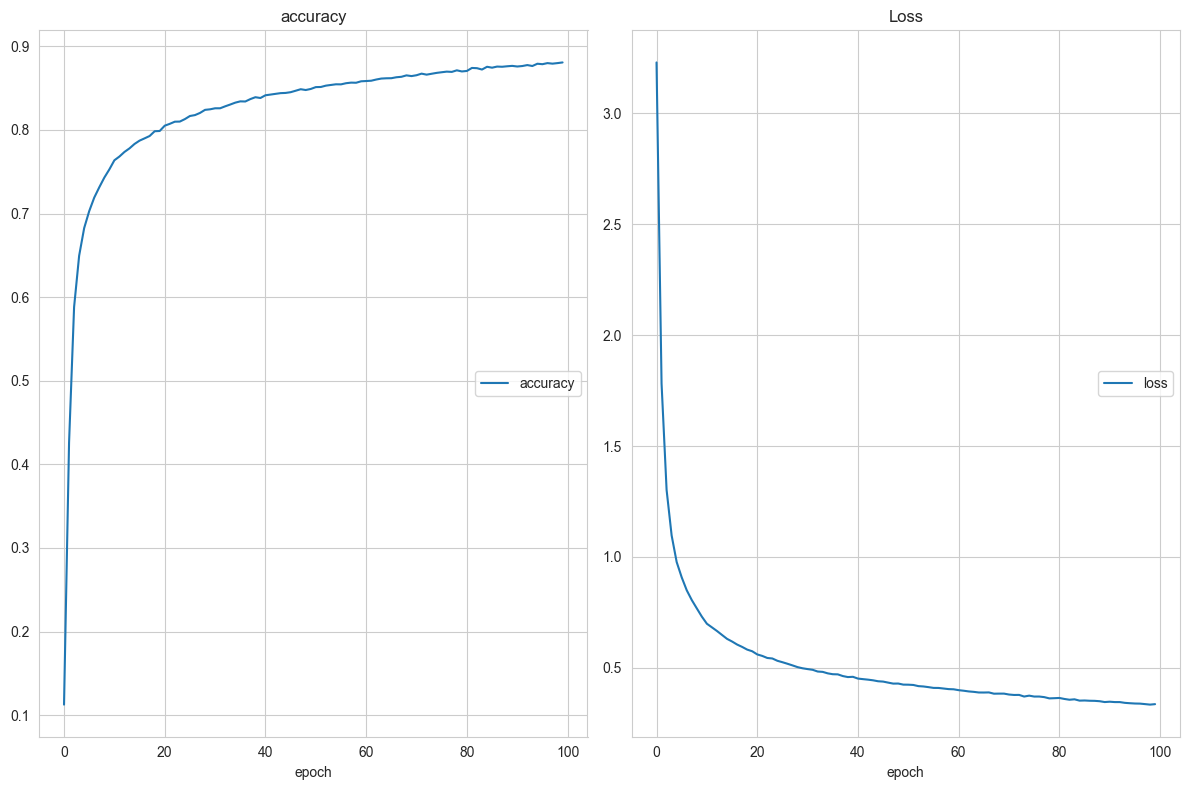

accuracy
	accuracy         	 (min:    0.113, max:    0.881, cur:    0.881)
Loss
	loss             	 (min:    0.335, max:    3.228, cur:    0.337)


In [42]:
EPOCHS = 100
LEARNING_RATE = 0.001

def train_model(train_dl, model):
    liveloss = PlotLosses()    
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc
            print(f'Epoch {epoch:03}:| Loss: {epoch_loss/len(train_dl):.5f}| Acc: {epoch_acc/len(train_dl):.3f}')      
            logs['loss'] = epoch_loss
            logs['accuracy'] = epoch_acc/len(train_dl)
            liveloss.update(logs)
            liveloss.send()

train_model(train_dl_all, model)


**Evaluate Model**

In [43]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

Accuracy: 0.848

acertou:8481 falhou:1519
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.95      0.97      0.96      1000
           2       0.79      0.76      0.78      1000
           3       0.85      0.84      0.85      1000
           4       0.77      0.80      0.79      1000
           5       0.89      0.93      0.91      1000
           6       0.67      0.61      0.64      1000
           7       0.91      0.89      0.90      1000
           8       0.94      0.95      0.95      1000
           9       0.93      0.92      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

[[807   8  15  43   2   6 103   1  14   1]
 [  1 966   1  21   5   2   3   0   1   0]
 [ 10   1 762  15 110   9  83   0  10   0]
 [ 46  35  18 843  27   3  21   1   5   1]
 [  1   3  80  36 802   2  

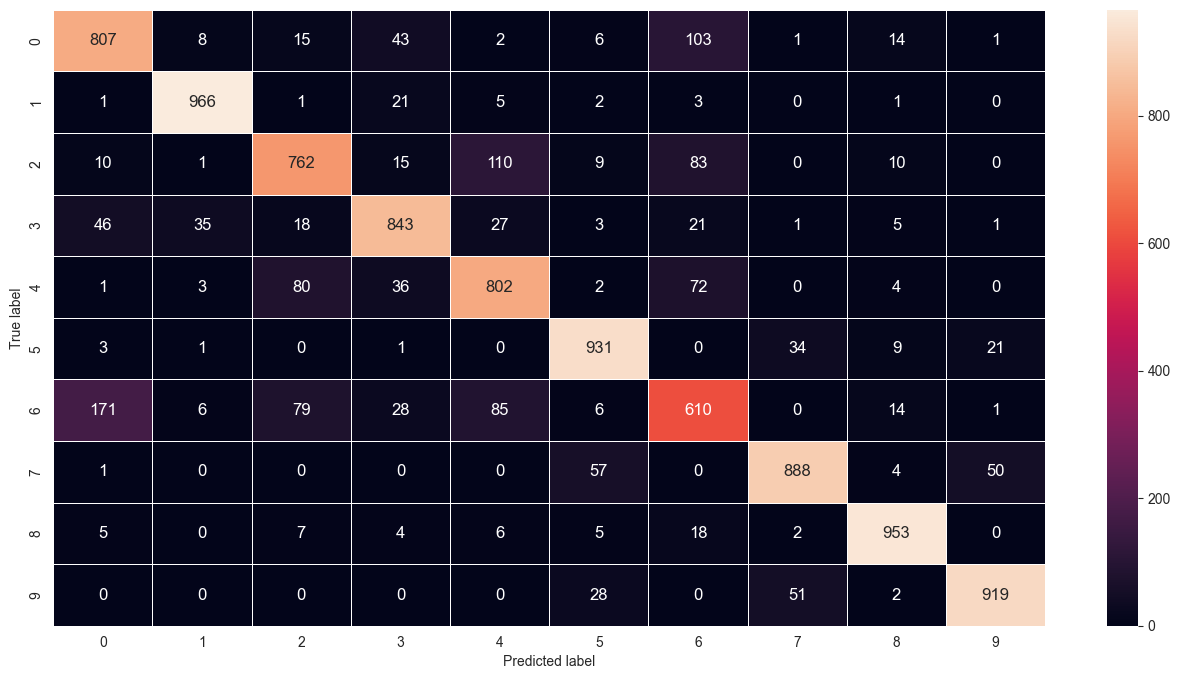

21

In [44]:
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, 
        fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

actual_values, predictions = evaluate_model(test_dl, model)
acertou=0
falhou = 0

for r,p in zip(actual_values, predictions):
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)
print (cm)
display_confusion_matrix(cm,list_classes)
21


**Use Model**

torch.Size([32, 784])
torch.float32
predict: 5


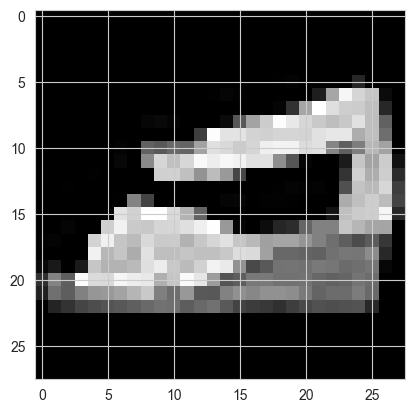

In [45]:
def make_prediction(model, img_list, idx):
    print(img_list.shape)
    print(img_list.dtype)
    img_list = img_list.to(device)
    prediction = model(img_list).detach().numpy()[idx].argmax()
    print("predict:",prediction)
    img = img_list[idx].reshape(1,28, 28)
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)
